# Setup

In [2]:
# Imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import shutil
import os

import utils

from classes import Tetraloop, Chain, Fragment
from collections import Counter, OrderedDict
from pathlib import Path
from pprint import pprint
from PyPDF2 import PdfWriter

In [4]:
# Paths
clusters_dir = Path('../../all_clusters/')
structures_dir = Path('../../all_structures/')
data_dir = Path('data/')
fragments_dir = Path('data/fragments/')
figures_dir = Path('figures/')
training_data_dir = Path('training_data/')

# Create figures directory if none exists
if not figures_dir.exists():
    figures_dir.mkdir(parents=True, exist_ok=True)

In [5]:
# Load all data

tloops_raw = utils.load(data_dir/'tloops_raw.pickle')
tloops_filtered = utils.load(data_dir/'tloops_filtered.pickle')

chains_annotated_raw = utils.load(data_dir/'chains_annotated_raw.pickle')
chains_annotated_filtered = utils.load(data_dir/'chains_annotated_filtered.pickle')

fragments_8_raw = utils.load(fragments_dir/'fragments_8_raw.pickle')
fragments_10_raw = utils.load(fragments_dir/'fragments_10_raw.pickle')
fragments_12_raw = utils.load(fragments_dir/'fragments_12_raw.pickle')
fragments_14_raw = utils.load(fragments_dir/'fragments_14_raw.pickle')
fragments_16_raw = utils.load(fragments_dir/'fragments_16_raw.pickle')
fragments_18_raw = utils.load(fragments_dir/'fragments_18_raw.pickle')
fragments_20_raw = utils.load(fragments_dir/'fragments_20_raw.pickle')
fragments_22_raw = utils.load(fragments_dir/'fragments_22_raw.pickle')
fragments_24_raw = utils.load(fragments_dir/'fragments_24_raw.pickle')

fragments_8_filtered = utils.load(fragments_dir/'fragments_8_filtered.pickle')
fragments_10_filtered = utils.load(fragments_dir/'fragments_10_filtered.pickle')
fragments_12_filtered = utils.load(fragments_dir/'fragments_12_filtered.pickle')
fragments_14_filtered = utils.load(fragments_dir/'fragments_14_filtered.pickle')
fragments_16_filtered = utils.load(fragments_dir/'fragments_16_filtered.pickle')
fragments_18_filtered = utils.load(fragments_dir/'fragments_18_filtered.pickle')
fragments_20_filtered = utils.load(fragments_dir/'fragments_20_filtered.pickle')
fragments_22_filtered = utils.load(fragments_dir/'fragments_22_filtered.pickle')
fragments_24_filtered = utils.load(fragments_dir/'fragments_24_filtered.pickle')

fragments_filtered = [fragments_8_filtered, fragments_10_filtered, fragments_12_filtered, fragments_14_filtered, fragments_16_filtered, fragments_18_filtered, fragments_20_filtered, fragments_22_filtered, fragments_24_filtered]
fragments_raw = [fragments_8_raw, fragments_10_raw, fragments_12_raw, fragments_14_raw, fragments_16_raw, fragments_18_raw, fragments_20_raw, fragments_22_raw, fragments_24_raw]

In [6]:
# Load metadata
metadata = pd.read_csv(data_dir/'RCSB_metadata.csv', header=[1]).dropna(axis=1, how='all')

In [10]:
def get_pdb_ids(data, unique=False, clusters=None):
    if clusters: pdb_ids = [i.pdb_id for i in data if i.clust_id in clusters]
    else: pdb_ids = [i.pdb_id for i in data]
    if unique: return set(pdb_ids)
    else: return pdb_ids


def get_seqs(data, unique=False, clusters=None):
    if clusters: seqs = [i.res_seq for i in data if i.clust_id in clusters]
    else: seqs = [i.res_seq for i in data]
    if unique: return set(seqs)
    else: return seqs


def get_counter_dict(data):
    return OrderedDict(Counter(data).most_common())

## PDB ID (metadata)

In [53]:
# # PDB ID query string for RCSB
# print(", ".join(set([i.pdb_id for i in tloops_raw])))

1j5e, 1e4p, 1yij, 2p89, 379d, 4u53, 2koc, 5dm6, 2ku0, 2zzm, 4qk9, 3w3s, 1hs3, 1zdh, 2uub, 1un6, 1zig, 2aht, 4gkk, 4v7x, 3d0x, 4zt9, 4v5a, 1hnw, 4v9o, 4v9k, 4wt8, 2uu9, 3lqx, 5mdz, 1dk1, 1k4a, 4v5k, 2pxb, 3g6e, 3zjv, 1nyb, 5doy, 1y39, 4v7w, 3skr, 1fyo, 1txs, 1zdi, 4wfm, 2ktz, 2tob, 4v7y, 1rlg, 4u1u, 2mqv, 3ndb, 1nwy, 2lhp, 5fkh, 5ibb, 2qex, 4w2h, 3j9m, 1ffk, 1kuq, 2euy, 2nc1, 4w2i, 2bny, 3e5f, 3ccu, 4y1j, 2n3r, 4b3t, 2v3c, 1q29, 4wqr, 5msf, 3skz, 2hua, 1i94, 2o44, 3rw6, 2n3q, 4v6a, 4v9p, 5fdu, 5fj1, 4e8p, 4c7o, 5j4d, 2lup, 1vqn, 1ldz, 4pqv, 4nxh, 5f98, 2oiu, 1r7z, 1yi2, 4b5r, 1vqm, 1rfr, 4oqu, 2i7e, 1xnq, 4u27, 3u4m, 4v8x, 4dv6, 4ji7, 4w4g, 5fk6, 3skw, 5jc9, 1hr2, 4k27, 4w92, 4k50, 4wsd, 5f8k, 1yjn, 2jyf, 4l47, 3rg5, 4wpo, 4v83, 4v9f, 3jct, 5dat, 5mrc, 3umy, 4v6c, 4ypb, 4wra, 5b2o, 1njp, 4dr3, 4lvx, 4p9r, 3iqp, 2jwv, 4v99, 2jxv, 2e5l, 4u3u, 4v6g, 2pxk, 5an9, 5dm7, 4un5, 4v8d, 1kqs, 4u55, 2uxc, 5ib8, 28sp, 5j02, 5j7l, 1q93, 3slm, 4v8c, 3adc, 4v7s, 5t62, 1n66, 5j4b, 5b2q, 2pxq, 1m90, 1s9s

In [10]:
def get_structure(pdb_id: str):
    matching_rows = metadata[metadata['Entry ID'] == pdb_id.upper()]
    if not matching_rows.empty:
        return matching_rows.iloc[0]["Stucture Keywords"]
    else:
        return ""


def get_organisms(pdb_id: str):
    organisms = []
    start_loc = metadata.index[metadata['Entry ID'] == pdb_id.upper()]
    if not start_loc.any(): return set(["N/A"])
    start_idx = start_loc.tolist()[0]
    for index, row in metadata.iloc[start_idx:].iterrows():
        if row['Entry ID'] == pdb_id.upper() or pd.isna(row['Entry ID']):
            organisms += [str(row["Source Organism"])]
        else: break
    return set([i for i in organisms if i != "nan"])

In [31]:
# Get structure and organism data

bottaro_structures = [get_structure(i).lower() for i in get_pdb_ids(tloops_filtered)]
generated_structures = [get_structure(i).lower() for i in get_pdb_ids(fragments_8_filtered, clusters=list(range(1,45)))]

bottaro_organisms = [j.lower() for i in get_pdb_ids(tloops_filtered) for j in get_organisms(i)]
generated_organisms = [j.lower() for i in get_pdb_ids(fragments_8_filtered, clusters=list(range(1,45))) for j in get_organisms(i)]

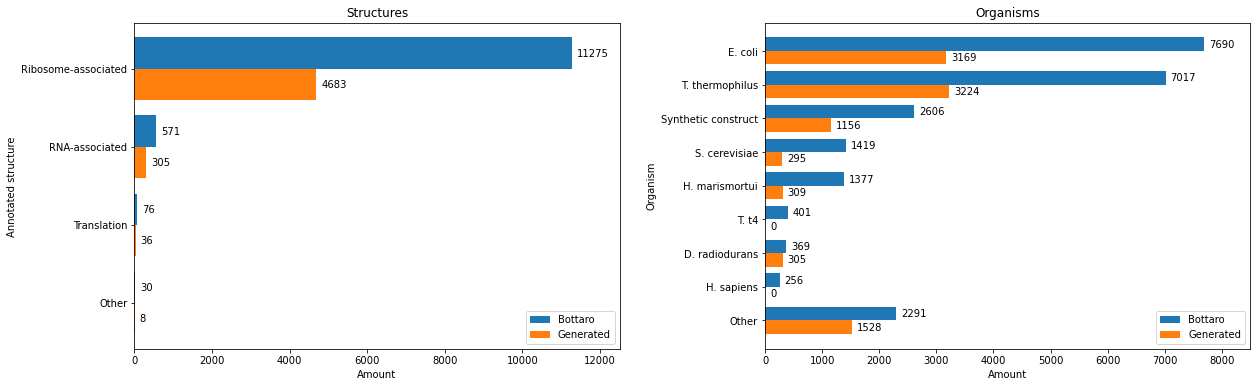

In [54]:
fig, axes = plt.subplots(1,2, figsize=(20, 6))
fig.subplots_adjust(wspace=0.3)
fig.tight_layout

bar_height = 0.4

# Structures

axes[0].set_title("Structures")
axes[0].set_ylabel("Annotated structure")
axes[0].set_xlabel("Amount")
axes[0].set_xlim([0, 12500])

other_limit = 20

# Bottaro tetraloops
bottaro_data = get_counter_dict(bottaro_structures)
bottaro_merged = {"Ribosome-associated": 0, "RNA-associated": 0, "Other": 0}
for structure, count in bottaro_data.items():
    if "ribosome" in structure: bottaro_merged["Ribosome-associated"] += count
    elif "rna" in structure:    bottaro_merged["RNA-associated"] += count
    elif count < other_limit:   bottaro_merged["Other"] += count
    else:                       bottaro_merged[structure.capitalize()] = count
bottaro_merged = dict(sorted(bottaro_merged.items(), key=lambda item: item[1]))
bottaro_merged = {'Other': bottaro_merged.pop('Other'), **bottaro_merged}

y_pos = np.arange(len(bottaro_merged))
bar = axes[0].barh(y_pos, bottaro_merged.values(), height=bar_height, align="edge")
axes[0].bar_label(bar, padding=5)
_ = axes[0].set_yticks(y_pos, labels=bottaro_merged.keys())

# Generated tetraloops
generated_data = get_counter_dict(generated_structures)
generated_merged = dict(zip(bottaro_merged.keys(), np.zeros(len(bottaro_merged))))
for structure, count in generated_data.items():
    if "ribosome" in structure: generated_merged["Ribosome-associated"] += count
    elif "rna" in structure:    generated_merged["RNA-associated"] += count
    elif count < other_limit:   generated_merged["Other"] += count
    else:                       generated_merged[structure.capitalize()] = count

bar = axes[0].barh(y_pos, generated_merged.values(), height=-bar_height, align="edge")
axes[0].bar_label(bar, padding=5)

axes[0].legend(labels=["Bottaro", "Generated"], loc="lower right")


# Organisms

axes[1].set_title("Organisms")
axes[1].set_ylabel("Organism")
axes[1].set_xlabel("Amount")
axes[1].set_xlim([0, 8500])

other_limit = 200

# Bottaro
bottaro_data = get_counter_dict(bottaro_organisms)
bottaro_merged = {"T. thermophilus": 0, "E. coli": 0, "S. cerevisiae": 0, "Other": 0}
for organism, count in bottaro_data.items():
    if "thermus thermophilus" in organism:          bottaro_merged["T. thermophilus"] += count
    elif "escherichia coli" in organism:            bottaro_merged["E. coli"] += count
    elif "saccharomyces cerevisiae" in organism:    bottaro_merged["S. cerevisiae"] += count
    elif count < other_limit:                       bottaro_merged["Other"] += count
    else:
        generic = organism.capitalize().split()[0][0] + ". "
        species = " ".join(organism.split()[1:])
        name = generic + species if organism != "synthetic construct" else organism.capitalize()
        bottaro_merged[name] = count
bottaro_merged = dict(sorted(bottaro_merged.items(), key=lambda item: item[1]))
bottaro_merged = {'Other': bottaro_merged.pop('Other'), **bottaro_merged}

y_pos = np.arange(len(bottaro_merged))
bar = axes[1].barh(y_pos, bottaro_merged.values(), height=bar_height, align="edge")
axes[1].bar_label(bar, padding=5)
_ = axes[1].set_yticks(y_pos, labels=bottaro_merged.keys())

# Generated
generated_data = get_counter_dict(generated_organisms)
generated_merged = dict(zip(bottaro_merged.keys(), np.zeros(len(bottaro_merged))))
for organism, count in generated_data.items():
    if "thermus thermophilus" in organism:          generated_merged["T. thermophilus"] += count
    elif "escherichia coli" in organism:            generated_merged["E. coli"] += count
    elif "saccharomyces cerevisiae" in organism:    generated_merged["S. cerevisiae"] += count
    elif count < other_limit:                       generated_merged["Other"] += count
    else:
        generic = organism.capitalize().split()[0][0] + ". "
        species = " ".join(organism.split()[1:])
        name = generic + species if organism != "synthetic construct" else organism.capitalize()
        generated_merged[name] = count

bar = axes[1].barh(y_pos, generated_merged.values(), height=-bar_height, align="edge")
axes[1].bar_label(bar, padding=5)

axes[1].legend(labels=["Bottaro", "Generated"], loc="lower right")

fig.savefig(figures_dir/"structures_organisms.png")

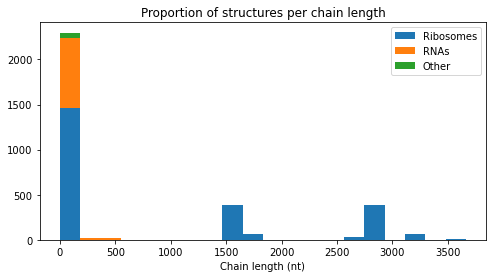

In [16]:
# Chain length vs. structure annotation

num_bins = 20


fig, ax = plt.subplots(figsize=(8,4))

ax.set_title("Proportion of structures per chain length")
ax.set_xlabel("Chain length (nt)")

chain_lengths = [len(i) for i in chains_annotated_raw]
bin_lims = np.linspace(min(chain_lengths), max(chain_lengths), num=num_bins+1)
bin_size = bin_lims[1] - bin_lims[0]

chain_bins = [[] for i in range(num_bins)]
for chain in chains_annotated_raw:
    bin_idx = int((len(chain))/bin_size)
    if bin_idx == num_bins: bin_idx -= 1
    chain_bins[bin_idx] += [chain]

size_counts = {"Ribosomes": np.zeros(num_bins), "RNAs": np.zeros(num_bins), "Other": np.zeros(num_bins)} 

for bin_idx, bin in enumerate(chain_bins):
    for chain in bin:
        structure = get_structure(chain.pdb_id).lower()
        if "ribosome" in structure: size_counts["Ribosomes"][bin_idx] += 1
        elif "rna" in structure:    size_counts["RNAs"][bin_idx] += 1
        else:                       size_counts["Other"][bin_idx] += 1

bottom = np.zeros(num_bins)
for boolean, size_count in size_counts.items():
    bars = ax.bar(bin_lims[:-1], size_count, width=bin_size, label=boolean, bottom=bottom, align='edge')
    # ax.bar_label(bars, [i if i > 30 else "" for i in size_count], padding=5)
    bottom += size_count

ax.legend(loc="upper right")

# Tetraloops
> The final tetraloop database is composed by 21,993 RNA fragments: 17,709 from X-ray, 3057 from NMR and 1227 from cryo-EM structures. The distributions of resolutions are shown in Fig. S1. [Bottaro et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5529312/)

According to Table SI1, there should be a total of 19383 tetraloops. I don't know where/what the remaining 2610 RNA fragments (from the total of 21993) are. The total number of "effective" tetraloops (members whose distance is above 0.07 eRMSD) is 16979.

In [26]:
# Unique sequences

generated_tloops = [i for i in fragments_8_filtered if i.clust_id in range(1,45)]
print(f"Set                 Total  Unique sequences  PDB IDs")
print(f"Bottaro (raw)       {len(tloops_raw):<7}{len(get_seqs(tloops_raw, unique=True)):<18}{len(get_pdb_ids(tloops_raw, unique=True))}")
print(f"Bottaro (filtered)  {len(tloops_filtered):<7}{len(get_seqs(tloops_filtered, unique=True)):<18}{len(get_pdb_ids(tloops_filtered, unique=True))}")
print(f"Generated           {len(generated_tloops):<7}{len(get_seqs(generated_tloops, unique=True)):<18}{len(get_pdb_ids(generated_tloops, unique=True))}")

Set                 Total  Unique sequences  PDB IDs
Bottaro (raw)       19383  292               864
Bottaro (filtered)  11952  292               864
Generated           5032   289               469


| Set                | Total | Unique sequences | PDB IDs |
|--------------------|-------|------------------|---------|
| Bottaro (raw)      | 19383 | 292              | 864     |
| Bottaro (filtered) | 11952 | 292              | 864     |
| Generated          | 5032  | 289              | 469     |

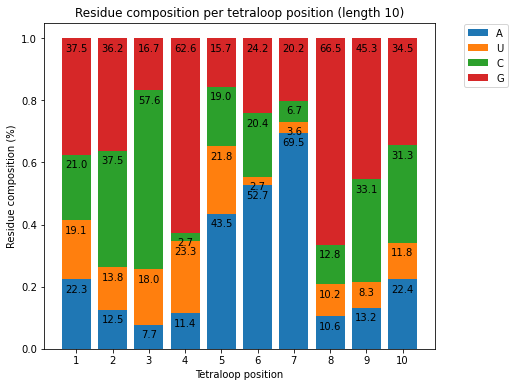

In [92]:
# Residue position histogram

tloops = [i for i in fragments_10_filtered if i.clust_id != 0] #!
# tloops = tloops_filtered #!

sequences = get_seqs(tloops)
res_names = ['A','U','C','G'] # N, I
sequence_length = len(sequences[0])
res_array = np.zeros(shape=(len(res_names), sequence_length))
for seq in sequences:
    for pos, res in enumerate(seq):
        res_array[res_names.index(res)][pos] += 1
res_array = res_array/res_array.sum(axis=0, keepdims=True)

fig, ax = plt.subplots(figsize=(sequence_length*0.7,6))
ax.set_title(f"Residue composition per tetraloop position (length {sequence_length})")
ax.set_xlabel("Tetraloop position")
ax.set_ylabel("Residue composition (%)")

positions = range(1, sequence_length+1)
ax.set_xticks(positions)

bottom = np.zeros(sequence_length)
for index, percentages in enumerate(res_array):
    bar = ax.bar(positions, percentages, bottom=bottom, label=res_names[index])
    ax.bar_label(bar, [round(i*100, 1) if i != 0 else "" for i in percentages], padding=-15)
    bottom += percentages

ax.legend(loc='upper right', bbox_to_anchor=(1.2,1.01))

In [108]:
# Missing Tetraloop sequences (found in Bottaro but not in Generated)

tloop_raw_seqs = set([i.res_seq for i in tloops_raw])
tloop_fragment_seqs = set([i.res_seq for i in fragments_8_raw if i.clust_id != 0])
missing_seqs = tloop_raw_seqs - tloop_fragment_seqs
print(f"Sequences missing from Fragments: {missing_seqs}")
missing_tloops = [i for i in tloops_raw if i.res_seq in missing_seqs]
print(f"{len(missing_tloops)} tetraloops missing from Fragments:")
for i in missing_tloops: print(f"{i.clust_id:<3}{i.pdb_id:6}{i.res_seq:10}{i.res_nums[0]}")

Sequences missing from Fragments: {'AGGUGACU', 'AGGCGACU', 'GCGUAAGC'}
39 tetraloops missing from Fragments:
1  2gcs  AGGCGACU  112
1  2gcv  AGGCGACU  112
1  2h0s  AGGCGACU  112
1  2h0w  AGGCGACU  112
1  2h0x  AGGCGACU  112
1  2h0z  AGGCGACU  112
1  2ho6  AGGCGACU  112
1  2ho7  AGGCGACU  112
1  2nz4  AGGUGACU  107
1  2nz4  AGGUGACU  107
1  2nz4  AGGUGACU  107
1  2nz4  AGGUGACU  107
1  2z74  AGGCGACU  112
1  2z75  AGGCGACU  112
1  3b4a  AGGCGACU  112
1  3b4b  AGGCGACU  112
1  3b4c  AGGCGACU  112
1  3g8s  AGGUGACU  107
1  3g8s  AGGUGACU  107
1  3g8s  AGGUGACU  107
1  3g8s  AGGUGACU  107
1  3g8t  AGGUGACU  107
1  3g96  AGGUGACU  107
1  3g96  AGGUGACU  107
1  3g96  AGGUGACU  107
1  3g96  AGGUGACU  107
1  3g9c  AGGUGACU  107
1  3g9c  AGGUGACU  107
1  3g9c  AGGUGACU  107
1  3g9c  AGGUGACU  107
1  3l3c  AGGUGACU  107
1  3l3c  AGGUGACU  107
1  3l3c  AGGUGACU  107
1  3l3c  AGGUGACU  107
1  4meg  AGGCGACU  93
1  4meh  AGGCGACU  93
1  4r4p  GCGUAAGC  734
1  4r4v  GCGUAAGC  734
25 3g8t  AGGUGACU  

# Chains

In [24]:
print(f"Set        Total  Unique sequences  PDB IDs")
print(f"Raw        {len(chains_annotated_raw):<7}{len(get_seqs(chains_annotated_raw, unique=True)):<18}{len(get_pdb_ids(chains_annotated_raw, unique=True))}")
print(f"Filtered   {len(chains_annotated_filtered):<7}{len(get_seqs(chains_annotated_filtered, unique=True)):<18}{len(get_pdb_ids(chains_annotated_filtered, unique=True))}")

Set        Total  Unique sequences  PDB IDs
Raw        3284   1032              864
Filtered   836    709               533


|           | Number of chains | Unique sequences | PDB IDs                             |
|-----------|------------------|------------------|-------------------------------------|
| Raw       | 3284             | 1032             | 864                                 |
| Filtered  | 836              | 709              | 536                                 |

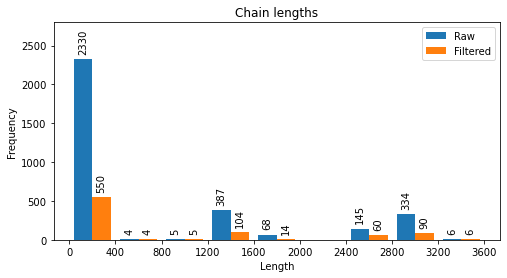

In [8]:
# Raw vs. filtered chain lengths

fig, ax = plt.subplots(figsize=(8, 4))

ax.set_title("Chain lengths")
ax.set_xlabel("Length")
ax.set_ylabel("Frequency")
ax.set_ylim([0, 2800])

data = [[len(i) for i in chains_annotated_raw], [len(i) for i in chains_annotated_filtered]]

values, _, bars = ax.hist(data, bins = range(0, max(data[0]), 400), label=["Raw", "Filtered"], rwidth=0.8)
ax.bar_label(bars[0], labels=[int(i) if i != 0 else "" for i in values[0]], rotation='vertical', padding=5)
ax.bar_label(bars[1], labels=[int(i) if i != 0 else "" for i in values[1]], rotation='vertical', padding=5)
ax.set_xticks(range(0, max(data[0]), 400))

ax.legend()
# fig.savefig(figures_dir/"chain_lengths.png")

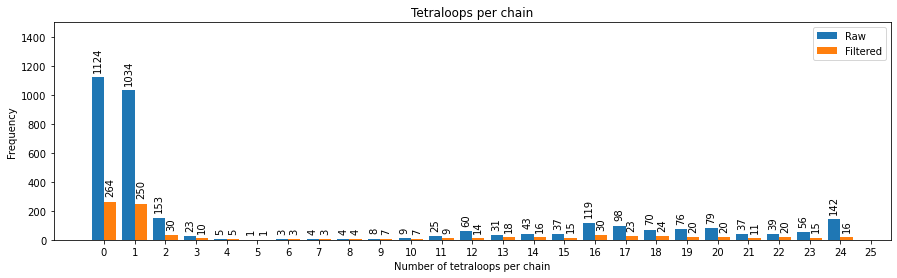

In [25]:
# Number of tetraloops per annotated chain
# why is the average number of tetraloops per PDB id so high (like 10 per pdb id)?
# check the chains with the highest number of tetraloops

fig, ax = plt.subplots(figsize=(15, 4))

ax.set_title("Tetraloops per chain")
ax.set_xlabel("Number of tetraloops per chain")
ax.set_ylabel("Frequency")
ax.set_ylim([0, 1500])

data = [[len(i.tloops) for i in chains_annotated_raw], [len(i.tloops) for i in chains_annotated_filtered]]

values, _, bars = ax.hist(data, bins = range(0, max(data[0])), label=["Raw", "Filtered"], rwidth=0.8, align="left")
ax.bar_label(bars[0], labels=[int(i) if i != 0 else "" for i in values[0]], rotation='vertical', padding=5)
ax.bar_label(bars[1], labels=[int(i) if i != 0 else "" for i in values[1]], rotation='vertical', padding=5)
ax.set_xticks(range(0, max(data[0])))

ax.legend()

In [ ]:
# TODO TETRALOOPS PER STRUCTURE?

# Fragments

## Unique sequences

For a sequence of length 8, the number of unique RNA sequences is $4^{8} = 65536$ (or $6^{8} = 1679616$, if residues I and N are included). 

Expected number of tries to obtain $x$ unique sequences:
$$\sum\limits_{i=0}^x \frac{n}{n-i}$$
where $n$ = total number of unique sequences

The expected number of tries needed to obtain *all* unique sequences of length 8 is $764646$.

In [132]:
# Possible number of unique fragments (assuming each residue is independent) vs. actual number of unique fragments (and expected number of tries to obtain said number)

print("Length  Total   Possible         Actual  Expected tries")
for length, fragments in zip(range(8,25,2), fragments_raw):
    possible_seqs = 4**length
    unique_seqs = len(get_seqs(fragments, unique=True))
    expected_tries = sum([possible_seqs/(possible_seqs-i) for i in range(unique_seqs)])
    # expected_tries_all = sum([possible_seqs/(possible_seqs-i) for i in range(possible_seqs)]) #! This is too computationally heavy
    print(f"{length:<8}{len(fragments):<8}{possible_seqs:<17}{unique_fragments:<8}{round(expected_tries):<8}") # {round(expected_tries_all)}

Length  Total   Possible         Actual  Expected tries
8       661843  65536            70737   53068   
10      660326  1048576          70737   60838   
12      658866  16777216         70737   64005   
14      657469  268435456        70737   65923   
16      656138  4294967296       70737   67302   
18      654867  68719476736      70737   68394   
20      653645  1099511627776    70737   69288   
22      652469  17592186044416   70737   70053   
24      651332  281474976710656  70737   70737   


In [22]:
# Decoy sizes

raw_decoys = [len([j for j in i if j.clust_id == 0]) for i in fragments_raw]
filtered_decoys = [len([j for j in i if j.clust_id == 0]) for i in fragments_filtered]

|          |      8 |     10 |     12 |     14 |     16 |     18 |     20 |     22 |     24 |
|----------|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|
| Raw      | 656811 | 655294 | 653841 | 652463 | 651147 | 649884 | 648678 | 647514 | 646391 |
| Filtered |  36323 |  58871 |  63532 |  65542 |  66919 |  68007 |  68903 |  69660 |  70347 |


In [104]:
# Check which decoy sequences also appear as tloops

tloop_seqs = get_seqs([i for i in fragments_8_raw if i.clust_id != 0], unique=True)
decoy_seqs = get_seqs([i for i in fragments_8_raw if i.clust_id == 0], unique=True)
intersection = tloop_seqs.intersection(decoy_seqs)
print(f"Tetraloop sequences: {len(tloop_seqs)}")
print(f"Tetraloop sequences that also appear in decoys: {len(intersection)}")

Tetraloop sequences: 289
Tetraloop sequences that also appear in decoys: 237


## Clusters

In [12]:
# Cluster groups, as named in Bottaro et al. Table SI1

gnra = [1]
gnra_like = [1, 3, 6, 9, 25, 26, 36, 40]
uncg = [2]
uncg_like = [2, 5, 37, 44]
u_turn = [4]

cluster_types = {1: "GNRA", 3: "GNRA-like", 6: "GNRA-like", 9: "GNRA-like", 25: "GNRA-like", 26: "GNRA-like", 36: "GNRA-like", 40: "GNRA-like", 2: "UNCG", 5: "UNCG-like", 37: "UNCG-like", 44: "UNCG-like", 4: "U-TURN", 7: "7", 8: "8", 10: "10", 11: "4-Stack", 12: "12", 34: "34", 13: "13", 20: "20", 14: "14", 19: "19", 15: "15", 16: "16", 17: "17", 18: "18", 21: "RNYA", 22: "22", 32: "32", 43: "43", 23: "23", 24: "24", 27: "27", 28: "28", 29: "29", 30: "GGUG", 31: "31", 33: "33", 35: "CUUG", 38: "CUUG", 39: "AGNN", 41: "41", 42: "42"}

In [21]:
# Number of fragments per tetraloop cluster

tloops_raw_counts = get_counter_dict([i.clust_id for i in tloops_raw])
tloops_raw_counts = dict(sorted(tloops_raw_counts.items(), key=lambda x:x[0]))

tloops_filtered_counts = get_counter_dict([i.clust_id for i in tloops_filtered])
tloops_filtered_counts = dict(sorted(tloops_filtered_counts.items(), key=lambda x:x[0]))

generated_counts = {}
for cluster in range(0,45):
    generated_counts[cluster] = [len([j for j in i if j.clust_id == cluster]) for i in fragments_filtered]

|            | Bottaro (raw) | Bottaro (filtered) | Generated |       |       |       |       |       |       |       |       |
|------------|---------------|--------------------|-----------|-------|-------|-------|-------|-------|-------|-------|-------|
|            |               |                    |         8 |    10 |    12 |    14 |    16 |    18 |    20 |    22 |    24 |
| 0 (decoys) |             0 |                  0 |     36323 | 58871 | 63532 | 65542 | 66919 | 68007 | 68903 | 69660 | 70347 |
|          1 |         10993 |               6855 |      2859 |  2859 |  2855 |  2849 |  2847 |  2846 |  2840 |  2834 |  2821 |
|          2 |          1664 |                765 |       318 |   318 |   318 |   318 |   314 |   314 |   310 |   305 |   305 |
|          3 |           543 |                400 |       166 |   166 |   166 |   166 |   166 |   166 |   166 |   166 |   166 |
|          4 |           522 |                305 |       116 |   116 |   116 |   111 |   111 |   111 |   111 |   110 |   110 |
|          5 |           468 |                314 |       142 |   142 |   142 |   142 |   142 |   142 |   142 |   142 |   142 |
|          6 |           373 |                281 |       121 |   121 |   121 |   121 |   120 |   120 |   119 |   119 |   118 |
|          7 |           351 |                253 |       103 |   103 |   103 |   103 |   103 |   103 |   103 |   103 |   103 |
|          8 |           332 |                216 |       127 |   127 |   127 |   127 |   127 |   127 |   127 |   127 |   127 |
|          9 |           306 |                188 |        81 |    81 |    81 |    81 |    80 |    80 |    80 |    80 |    80 |
|         10 |           284 |                231 |        78 |    78 |    78 |    78 |    78 |    78 |    78 |    78 |    78 |
|         11 |           265 |                198 |        90 |    90 |    90 |    90 |    90 |    90 |    90 |    90 |    90 |
|         12 |           258 |                178 |        90 |    90 |    90 |    90 |    90 |    90 |    90 |    90 |    90 |
|         13 |           251 |                161 |        65 |    65 |    65 |    65 |    65 |    65 |    65 |    65 |    65 |
|         14 |           231 |                157 |        63 |    63 |    63 |    63 |    63 |    63 |    63 |    63 |    63 |
|         15 |           229 |                155 |        88 |    88 |    88 |    88 |    88 |    88 |    88 |    88 |    88 |
|         16 |           211 |                135 |        71 |    71 |    71 |    71 |    71 |    71 |    71 |    71 |    71 |
|         17 |           208 |                128 |        66 |    66 |    66 |    66 |    66 |    66 |    66 |    66 |    66 |
|         18 |           206 |                156 |        57 |    57 |    57 |    57 |    57 |    57 |    57 |    57 |    57 |
|         19 |           199 |                154 |        75 |    75 |    75 |    75 |    75 |    75 |    75 |    75 |    75 |
|         20 |           151 |                119 |        51 |    51 |    51 |    51 |    51 |    51 |    51 |    51 |    51 |
|         21 |           139 |                 87 |        41 |    41 |    38 |    30 |    24 |    19 |    16 |    16 |    16 |
|         22 |           124 |                 67 |        41 |    41 |    41 |    41 |    41 |    41 |    41 |    41 |    41 |
|         23 |           120 |                  1 |         1 |     1 |     1 |     1 |     1 |     0 |     0 |     0 |     0 |
|         24 |            82 |                 51 |        25 |    25 |    25 |    25 |    25 |    25 |    25 |    25 |    25 |
|         25 |            68 |                 41 |        14 |    14 |    14 |    14 |    14 |    14 |    14 |    14 |    14 |
|         26 |            61 |                 61 |        14 |    14 |    14 |    14 |    14 |    14 |    14 |    14 |    14 |
|         27 |            61 |                 33 |         1 |     1 |     1 |     1 |     1 |     1 |     1 |     1 |     1 |
|         28 |            59 |                 31 |         7 |     7 |     7 |     7 |     7 |     7 |     7 |     7 |     7 |
|         29 |            57 |                 31 |         7 |     7 |     7 |     7 |     7 |     6 |     5 |     5 |     5 |
|         30 |            57 |                  5 |         4 |     4 |     4 |     4 |     4 |     4 |     3 |     3 |     3 |
|         31 |            57 |                 39 |         5 |     5 |     5 |     5 |     5 |     5 |     5 |     5 |     5 |
|         32 |            48 |                 36 |        13 |    13 |    13 |    13 |    13 |    13 |    13 |    13 |    13 |
|         33 |            46 |                 32 |         5 |     5 |     5 |     5 |     5 |     5 |     5 |     5 |     5 |
|         34 |            42 |                  7 |         3 |     3 |     3 |     3 |     3 |     3 |     3 |     3 |     3 |
|         35 |            42 |                  2 |         1 |     1 |     1 |     1 |     1 |     1 |     1 |     1 |     1 |
|         36 |            40 |                  2 |         1 |     1 |     1 |     1 |     1 |     1 |     1 |     1 |     1 |
|         37 |            35 |                  2 |         1 |     1 |     1 |     1 |     1 |     1 |     1 |     1 |     1 |
|         38 |            34 |                  2 |         1 |     1 |     1 |     1 |     1 |     1 |     1 |     1 |     1 |
|         39 |            32 |                  3 |         2 |     2 |     2 |     2 |     1 |     1 |     1 |     1 |     1 |
|         40 |            32 |                 21 |         7 |     7 |     7 |     7 |     7 |     7 |     7 |     7 |     7 |
|         41 |            29 |                  1 |         1 |     1 |     1 |     1 |     1 |     1 |     1 |     1 |     1 |
|         42 |            28 |                 28 |         2 |     2 |     2 |     2 |     2 |     2 |     2 |     2 |     2 |
|         43 |            25 |                 18 |         6 |     6 |     6 |     6 |     6 |     6 |     6 |     6 |     6 |
|         44 |            20 |                  2 |         2 |     2 |     2 |     2 |     2 |     2 |     2 |     2 |     2 |
| Tetraloops |         19383 |              11952 |      5032 |  5032 |  5025 |  5006 |  4991 |  4983 |  4967 |  4955 |  4941 |
| Total      |         19383 |              11952 |     41363 | 63913 | 68569 | 70562 | 71926 | 73008 | 73890 | 74637 | 75312 |

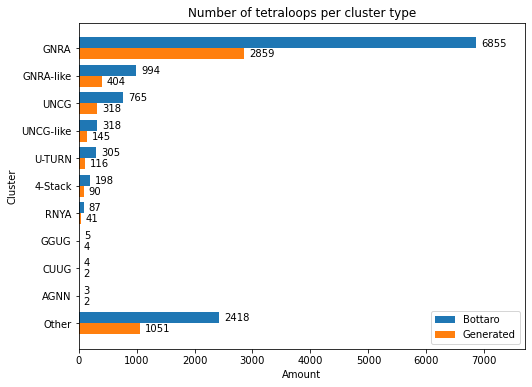

In [13]:
# Cluster analysis

height = 0.4

fig, ax = plt.subplots()
ax.set_title("Number of tetraloops per cluster type")
ax.set_xlabel("Amount")
ax.set_ylabel("Cluster")
ax.set_xlim([0, 7700])

named_clusters = [i for i in cluster_types.values() if not i.isdigit()]

# Bottaro 
bottaro_data = get_counter_dict([i.clust_id for i in tloops_filtered])

bottaro_merged = dict(zip(named_clusters, np.zeros(len(named_clusters))))
bottaro_merged["Other"] = 0
for cluster, count in bottaro_data.items():
    cluster_name = cluster_types[cluster]
    if cluster_name.isdigit():  bottaro_merged["Other"] += count
    else:                       bottaro_merged[cluster_types[cluster]] += count
bottaro_merged = dict(reversed(list(bottaro_merged.items())))

bar = ax.barh(range(len(bottaro_merged)), bottaro_merged.values(), height=height, align="edge")
ax.set_yticks(range(len(bottaro_merged)), labels=bottaro_merged.keys())
ax.bar_label(bar, [int(i) for i in bottaro_merged.values()], padding=5)

# Generated
generated_data = get_counter_dict([i.clust_id for i in fragments_8_filtered if i.clust_id in range(1,45)])

generated_merged = dict(zip(named_clusters, np.zeros(len(named_clusters))))
generated_merged["Other"] = 0
for cluster, count in generated_data.items():
    cluster_name = cluster_types[cluster]
    if cluster_name.isdigit():  generated_merged["Other"] += count
    else:                       generated_merged[cluster_types[cluster]] += count
generated_merged = dict(reversed(list(generated_merged.items())))

bar = ax.barh(range(len(generated_merged)), generated_merged.values(), height=-height, align="edge")
ax.bar_label(bar, [int(i) for i in generated_merged.values()], padding=5)

ax.legend(labels=["Bottaro", "Generated"], loc = "lower right")


## Training datasets

In [ ]:
# train/dev/test ratios and % positive examples

training_data = {}

for dir in os.listdir(training_data_dir):
    if os.path.isfile(training_data_dir/dir): continue
    if dir[-1] == "T": continue

    data_dict = {}
    total = 0
    positives = 0

    for file in os.listdir(training_data_dir/dir):
        if file.endswith('.csv') or file.endswith('.npz'): continue

        name = file.split("_")[0]
        labels = np.load(training_data_dir/dir/file)
        data_dict[name] = len(labels)
        
        total += len(labels)
        positives += np.count_nonzero(labels == 1)
    
    data_dict["total"] = total
    data_dict["positive"] = positives
    data_dict = dict(sorted(zip(data_dict.keys(), data_dict.values())))

    data_name = "_".join(dir.split("_")[:2])
    training_data[data_name] = data_dict


# for name, data in training_data.items():
#     print(name, data)

|          | length | train | dev  | test | positive | total |
|----------|--------|-------|------|------|----------|-------|
| clusters |     18 | 58392 | 7299 | 7299 |     2846 | 72990 |
| clusters |     12 | 54845 | 6856 | 6856 |     2855 | 68557 |
| clusters |     14 | 56438 | 7055 | 7055 |     2849 | 70548 |
| clusters |     24 | 60230 | 7529 | 7529 |     2821 | 75288 |
| clusters |     16 | 57528 | 7191 | 7191 |     2847 | 71910 |
| clusters |     10 | 51122 | 6390 | 6391 |     2859 | 63903 |
| clusters |      8 | 33084 | 4135 | 4136 |     2859 | 41355 |
| clusters |     20 | 59096 | 7387 | 7387 |     2840 | 73870 |
| clusters |     22 | 59692 | 7461 | 7462 |     2834 | 74615 |
| gnra     |     24 |  3952 |  494 |  495 |     2821 |  4941 |
| gnra     |     10 |  4025 |  503 |  504 |     2859 |  5032 |
| gnra     |     16 |  3992 |  499 |  500 |     2847 |  4991 |
| gnra     |     22 |  3964 |  495 |  496 |     2834 |  4955 |
| gnra     |     14 |  4004 |  501 |  501 |     2849 |  5006 |
| gnra     |     18 |  3986 |  498 |  499 |     2846 |  4983 |
| gnra     |     20 |  3973 |  497 |  497 |     2840 |  4967 |
| gnra     |     12 |  4020 |  502 |  503 |     2855 |  5025 |
| gnra     |      8 |  4025 |  503 |  504 |     2859 |  5032 |
| gnravall |     10 | 51122 | 6390 | 6391 |     2859 | 63903 |
| gnravall |     14 | 56438 | 7055 | 7055 |     2849 | 70548 |
| gnravall |      8 | 33084 | 4135 | 4136 |     2859 | 41355 |
| gnravall |     12 | 54845 | 6856 | 6856 |     2855 | 68557 |
| tloop    |     18 | 58392 | 7299 | 7299 |     4983 | 72990 |
| tloop    |      8 | 33084 | 4135 | 4136 |     5032 | 41355 |
| tloop    |     22 | 59692 | 7461 | 7462 |     4955 | 74615 |
| tloop    |     16 | 57528 | 7191 | 7191 |     4991 | 71910 |
| tloop    |     10 | 51122 | 6390 | 6391 |     5032 | 63903 |
| tloop    |     14 | 56438 | 7055 | 7055 |     5006 | 70548 |
| tloop    |     20 | 59096 | 7387 | 7387 |     4967 | 73870 |
| tloop    |     12 | 54845 | 6856 | 6856 |     5025 | 68557 |
| tloop    |     24 | 60230 | 7529 | 7529 |     4941 | 75288 |